In [61]:
import os
import sys
import math
import argparse
import numpy as np
from collections import Counter

# Keras imports
from keras.models import Model
from keras import backend as K

# ML4CVD Imports
from ml4cvd.arguments import parse_args
from ml4cvd.models import make_multimodal_multitask_model, train_model_from_generators
from ml4cvd.tensor_generators import TensorGenerator, big_batch_from_minibatch_generator, test_train_valid_tensor_generators

# IPython imports
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt


In [62]:
def gradients_from_output(args, model, output_layer, output_index):
    K.set_learning_phase(1)
    input_tensor = model.input
    x = model.get_layer(output_layer).output[:,output_index]
    grads = K.gradients(x, input_tensor)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-6) # normalization trick: we normalize the gradient
    iterate = K.function([input_tensor], [x, grads])
    return iterate

def saliency_map(input_tensor, model, output_layer, output_index):
    get_gradients = gradients_from_output(args, model, output_layer, output_index)
    activation, grads = get_gradients([input_tensor])
    print('Activation is:', activation, 'gradient shape:', grads.shape)
    return grads


In [63]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/brain-tensors-22k/2019-11-19/', 
            '--input_tensors', 't2_flair_brain_30_slices', 
            '--output_tensors', 'age_2',
            '--batch_size', '4',
            '--test_steps', '2',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/t2_flair_brain_age_converge.hd5',
            '--id', 'brain_age']

args = parse_args()
_, _, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
test_data, test_labels, test_paths = big_batch_from_minibatch_generator(generate_test, args.test_steps)

2019-12-05 16:00:56,610 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/brain_age/log_2019-12-05_16-00_0.log.
2019-12-05 16:00:56,611 - arguments:197 - INFO - Command Line was:

./scripts/tf.sh train --tensors /mnt/disks/brain-tensors-22k/2019-11-19/ --input_tensors t2_flair_brain_30_slices --output_tensors age_2 --batch_size 4 --test_steps 2 --model_file /mnt/ml4cvd/projects/jamesp/data/models/t2_flair_brain_age_converge.hd5 --id brain_age



2019-12-05 16:00:56,613 - arguments:198 - INFO - Total TensorMaps:336 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=4, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=1000000000.0, categorical_field_ids=[], continuous_field_ids=[], conv_bn=False, conv_dilate=False, conv_dropout=0.

2019-12-05 16:01:02,673 - tensor_generators:110 - INFO - Starting test_worker_0.
2019-12-05 16:01:02,679 - tensor_generators:234 - INFO - test_worker_0 initialized cache of size 0.997 GB.
2019-12-05 16:01:02,709 - tensor_generators:110 - INFO - Starting test_worker_1.
2019-12-05 16:01:02,720 - tensor_generators:234 - INFO - test_worker_1 initialized cache of size 0.997 GB.
2019-12-05 16:01:02,750 - tensor_generators:110 - INFO - Starting test_worker_2.
2019-12-05 16:01:02,766 - tensor_generators:234 - INFO - test_worker_2 initialized cache of size 0.997 GB.
2019-12-05 16:01:02,808 - tensor_generators:110 - INFO - Starting test_worker_3.
2019-12-05 16:01:02,824 - tensor_generators:234 - INFO - test_worker_3 initialized cache of size 0.997 GB.
2019-12-05 16:01:05,699 - tensor_generators:361 - INFO - big_batch_from_minibatch 50.00% done.
2019-12-05 16:01:05,958 - tensor_generators:372 - INFO - Tensor 'input_t2_flair_brain_30_slices_ukb_brain_mri' has shape (8, 192, 256, 30).
2019-12-05 16

In [64]:
def plot_brain(brain, cols=3, rows=10):
    _, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    vmin = np.min(brain)
    vmax = np.max(brain)
    for i in range(test_tensor.shape[-1]):
        axes[i//cols, i%cols].imshow(brain[:, :, i], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i//cols, i%cols].set_yticklabels([])
        axes[i//cols, i%cols].set_xticklabels([])    

(8, 192, 256, 30) (1, 192, 256, 30)


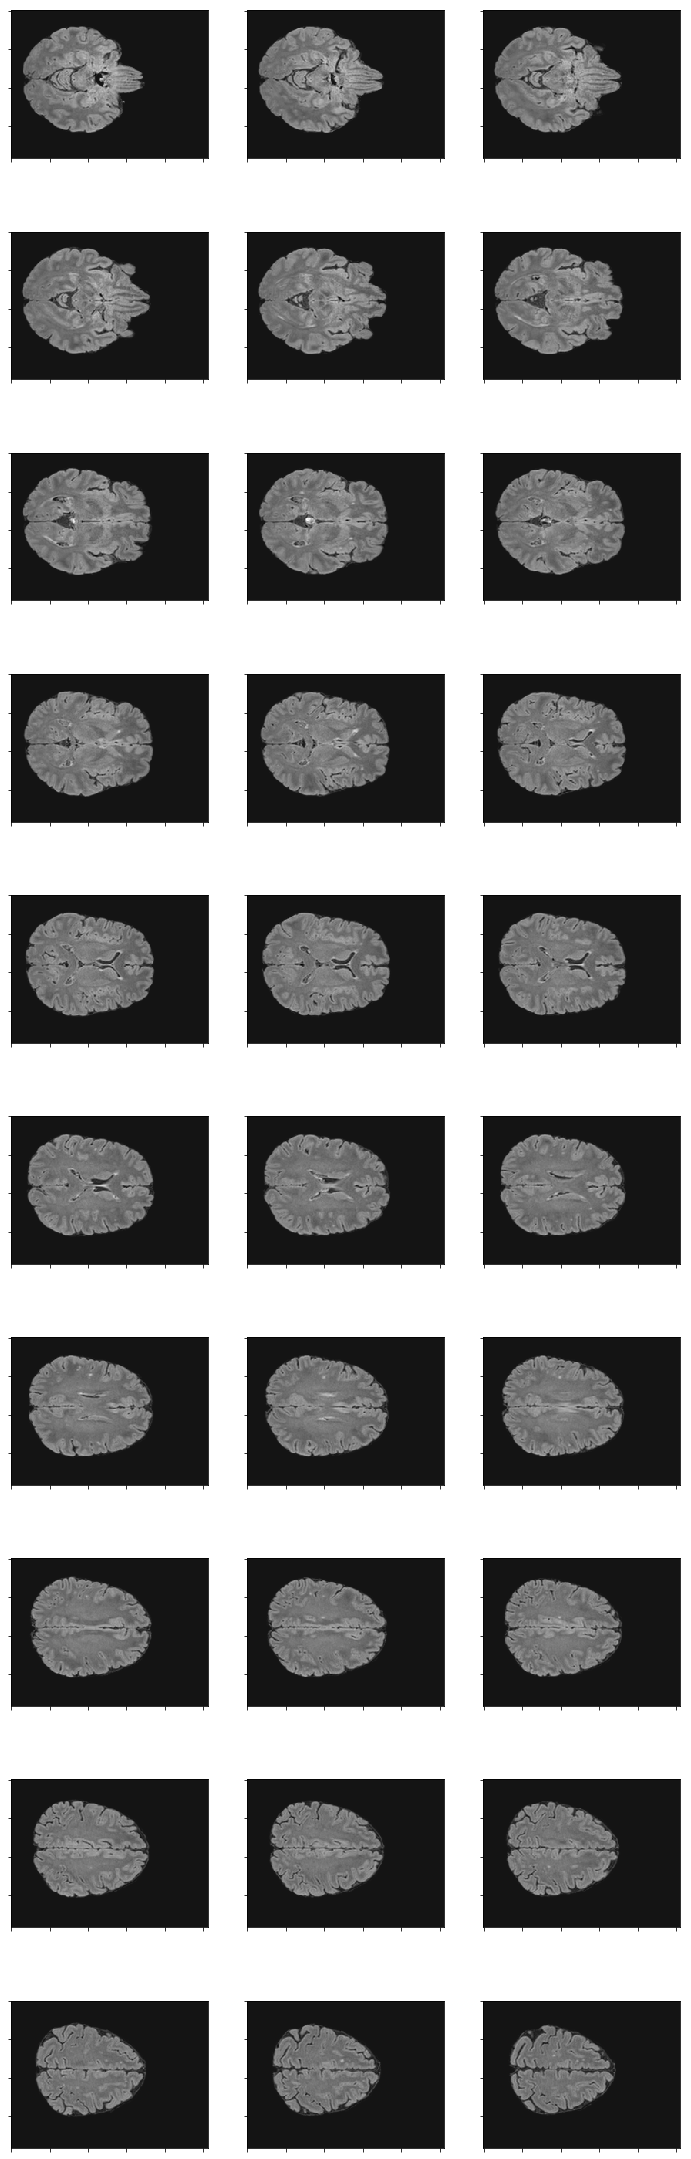

In [65]:
test_tensor = test_data['input_t2_flair_brain_30_slices_ukb_brain_mri']
print(test_tensor.shape, test_tensor[:1].shape)
plot_brain(test_tensor[0])

Activation is: [-0.7721615   0.81259453 -0.14580661 -0.11204708 -0.8817893   1.0030773 ] gradient shape: (6, 192, 256, 30)


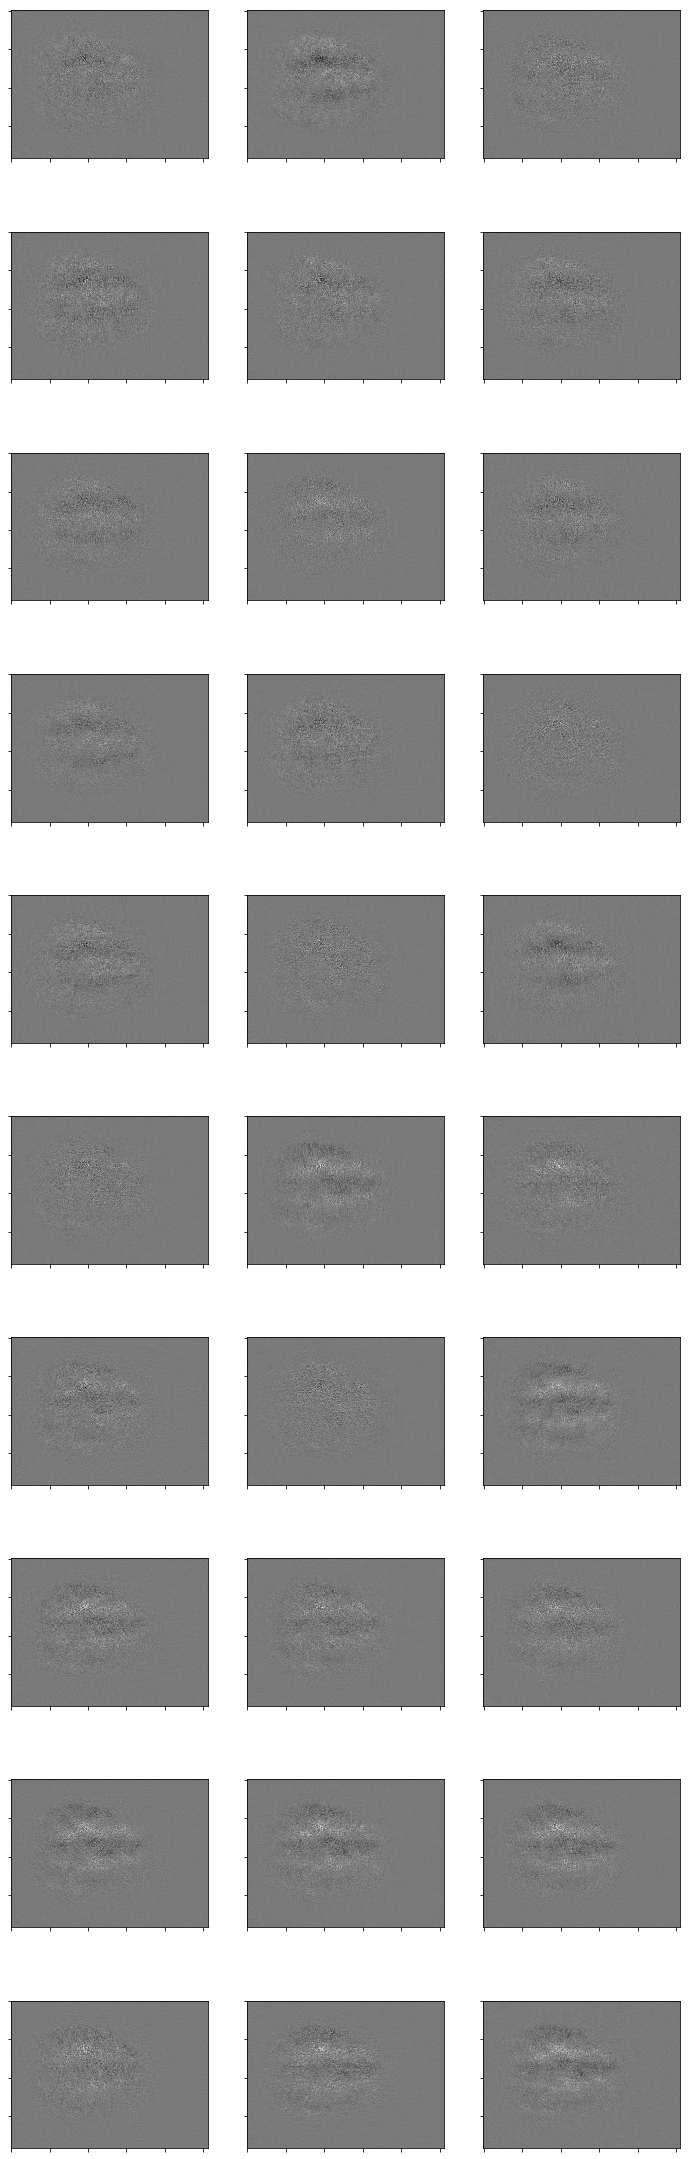

In [66]:
grads = saliency_map(test_tensor[:6], model, 'output_21003_Age-when-attended-assessment-centre_2_continuous', 0)
plot_brain(grads[0])

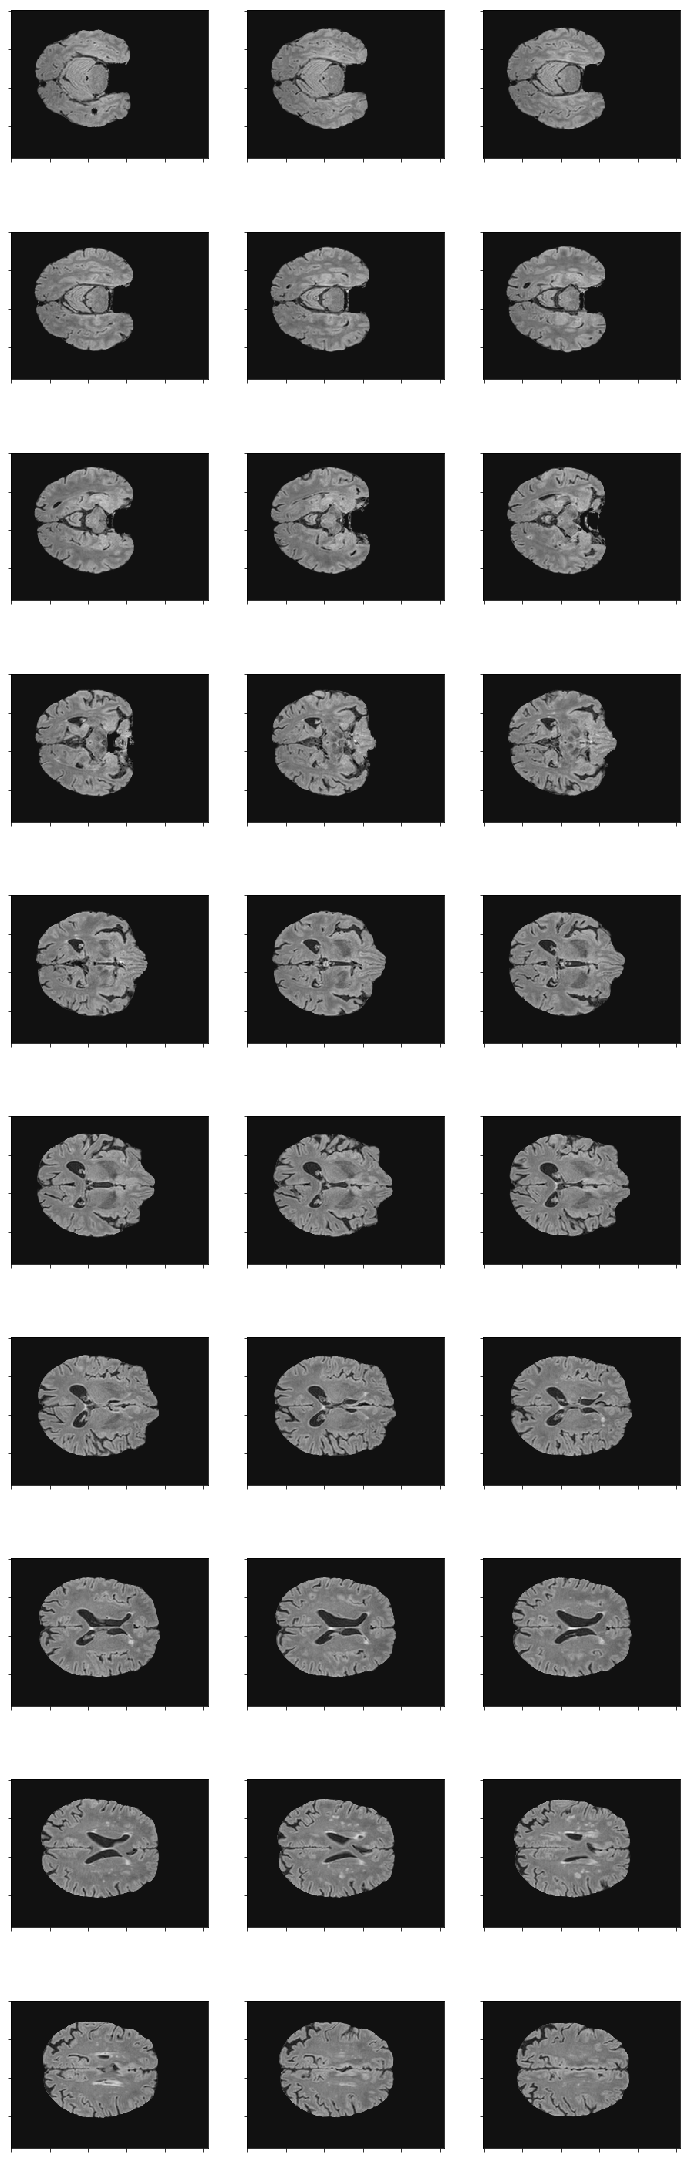

In [52]:
plot_brain(test_tensor[1])

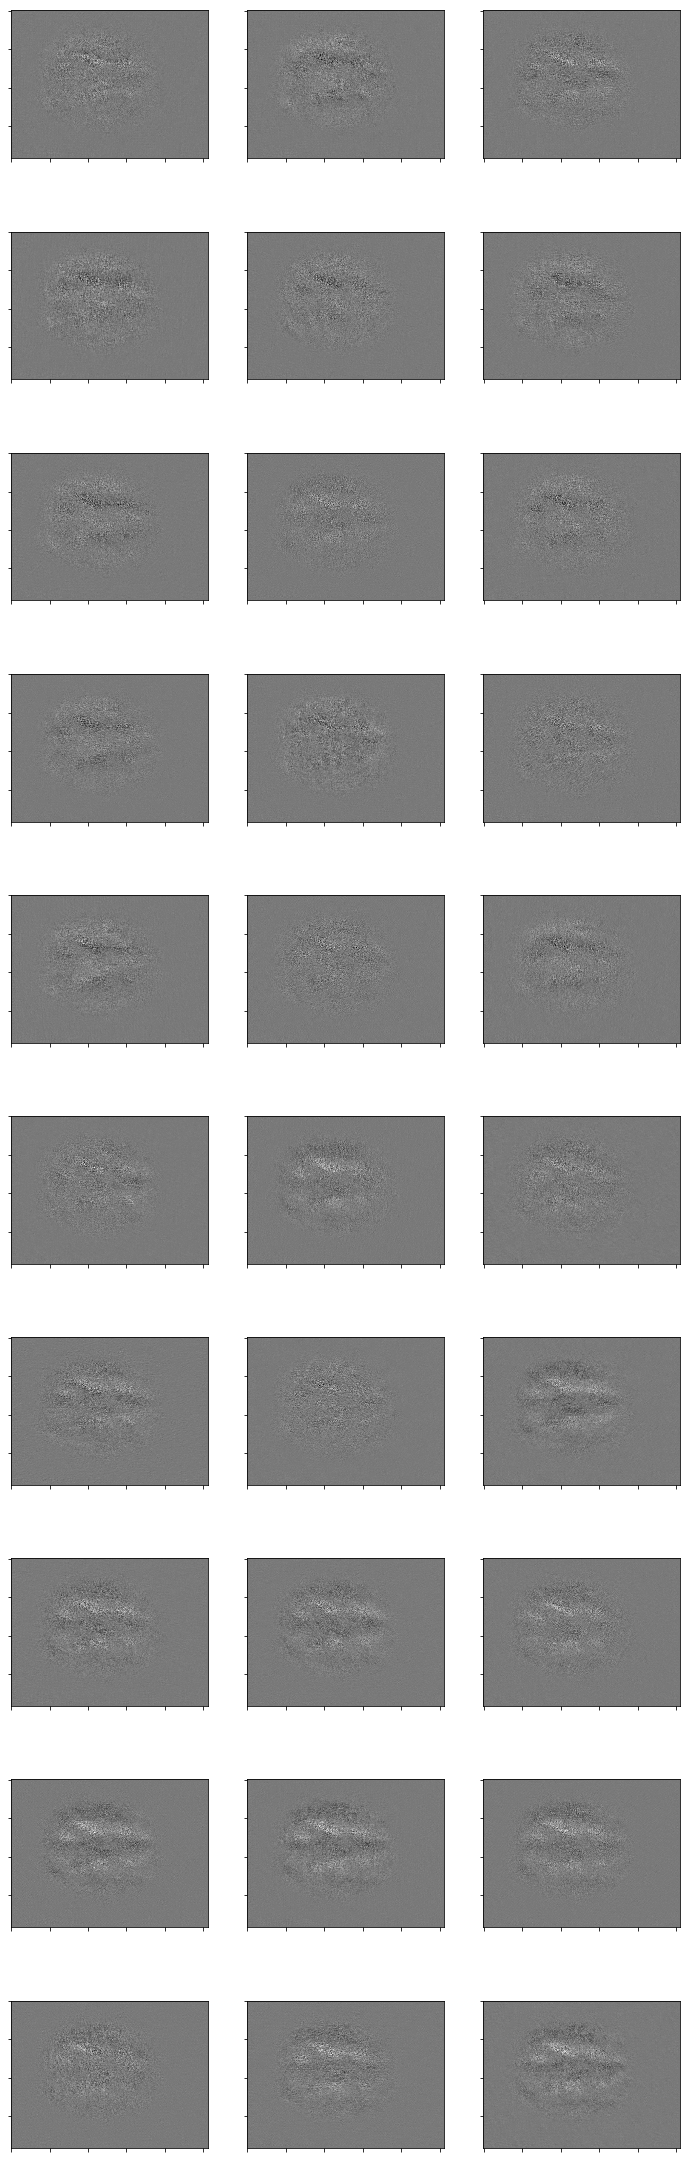

In [53]:
plot_brain(grads[1])

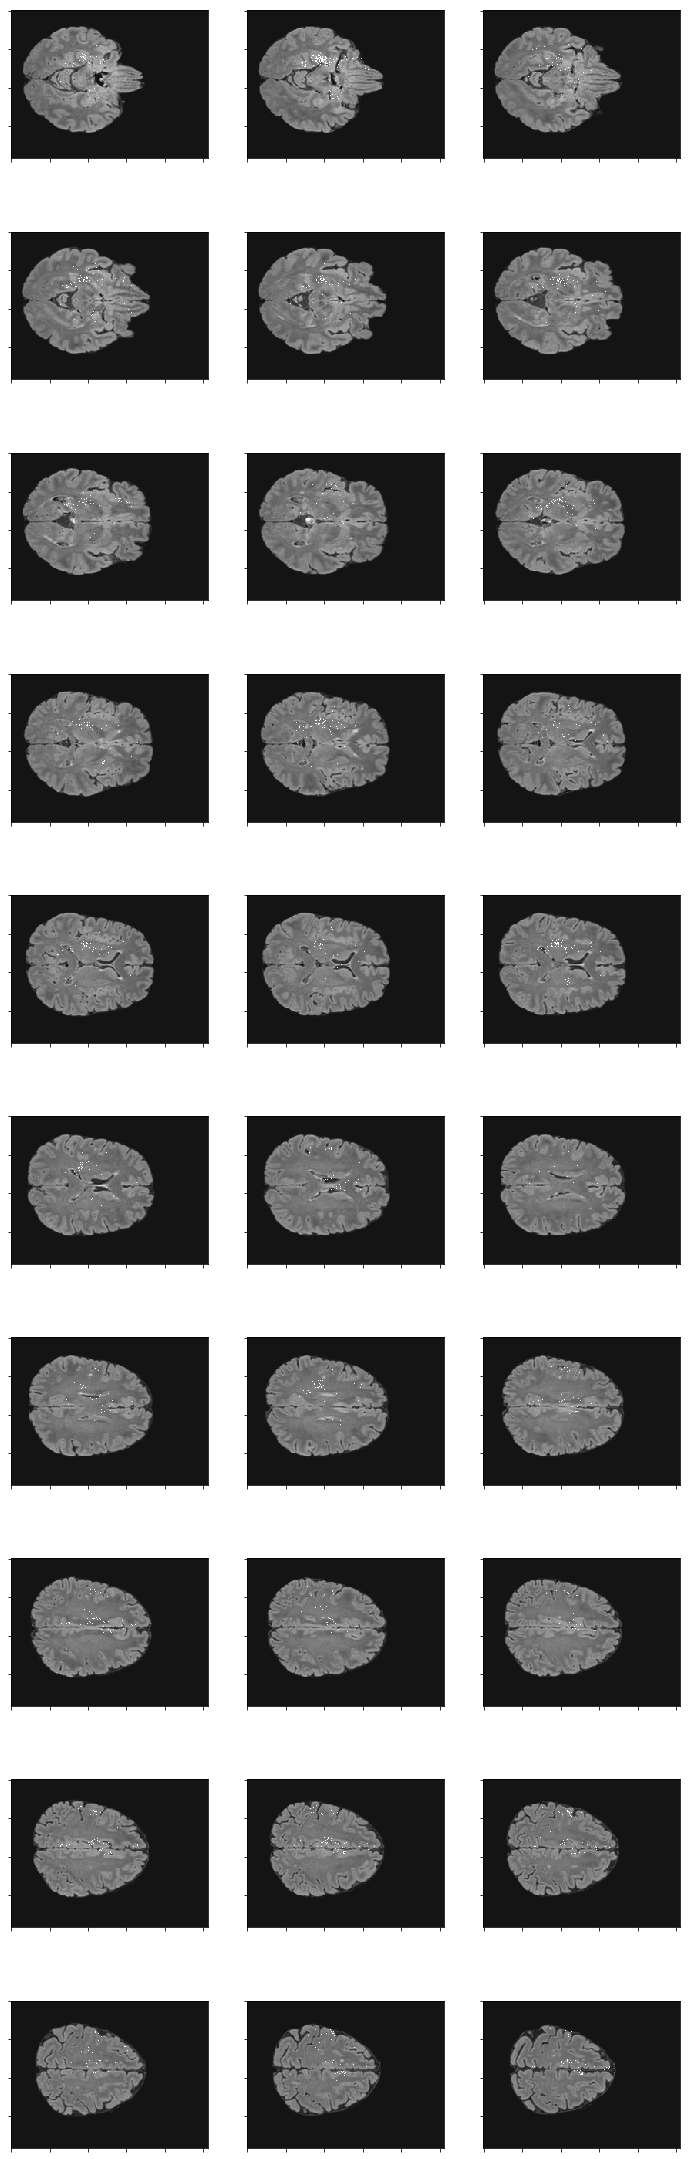

In [71]:
plot_brain(np.ma.masked_where(grads[0] < -5, test_tensor[0]))

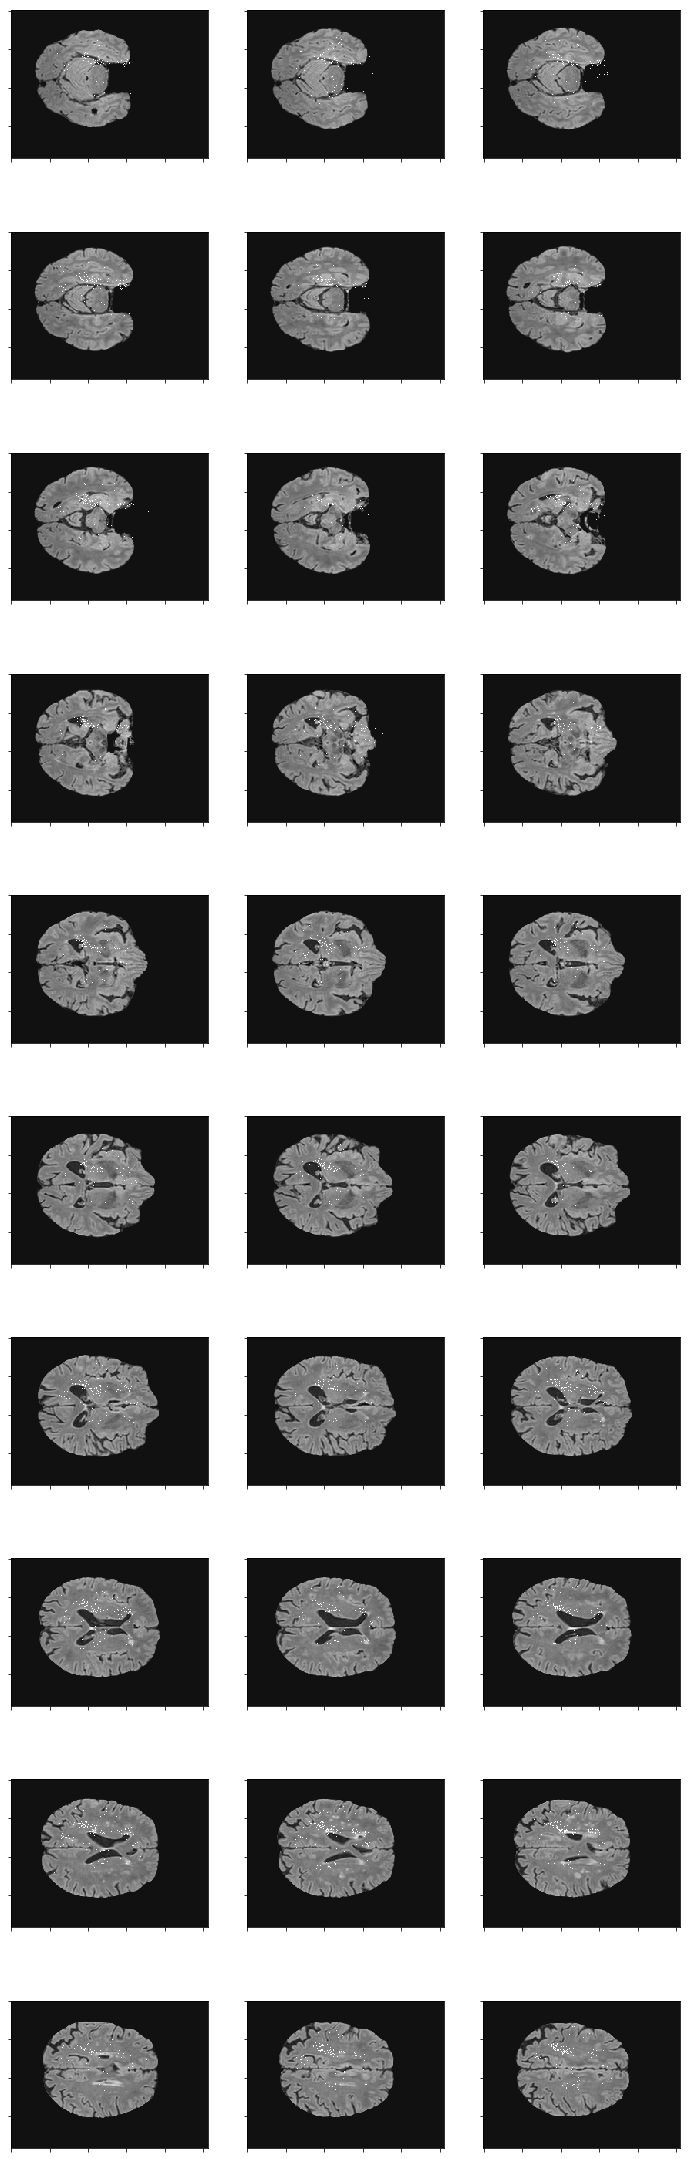

In [55]:
plot_brain(np.ma.masked_where(grads[1]) > 3, test_tensor[1]))

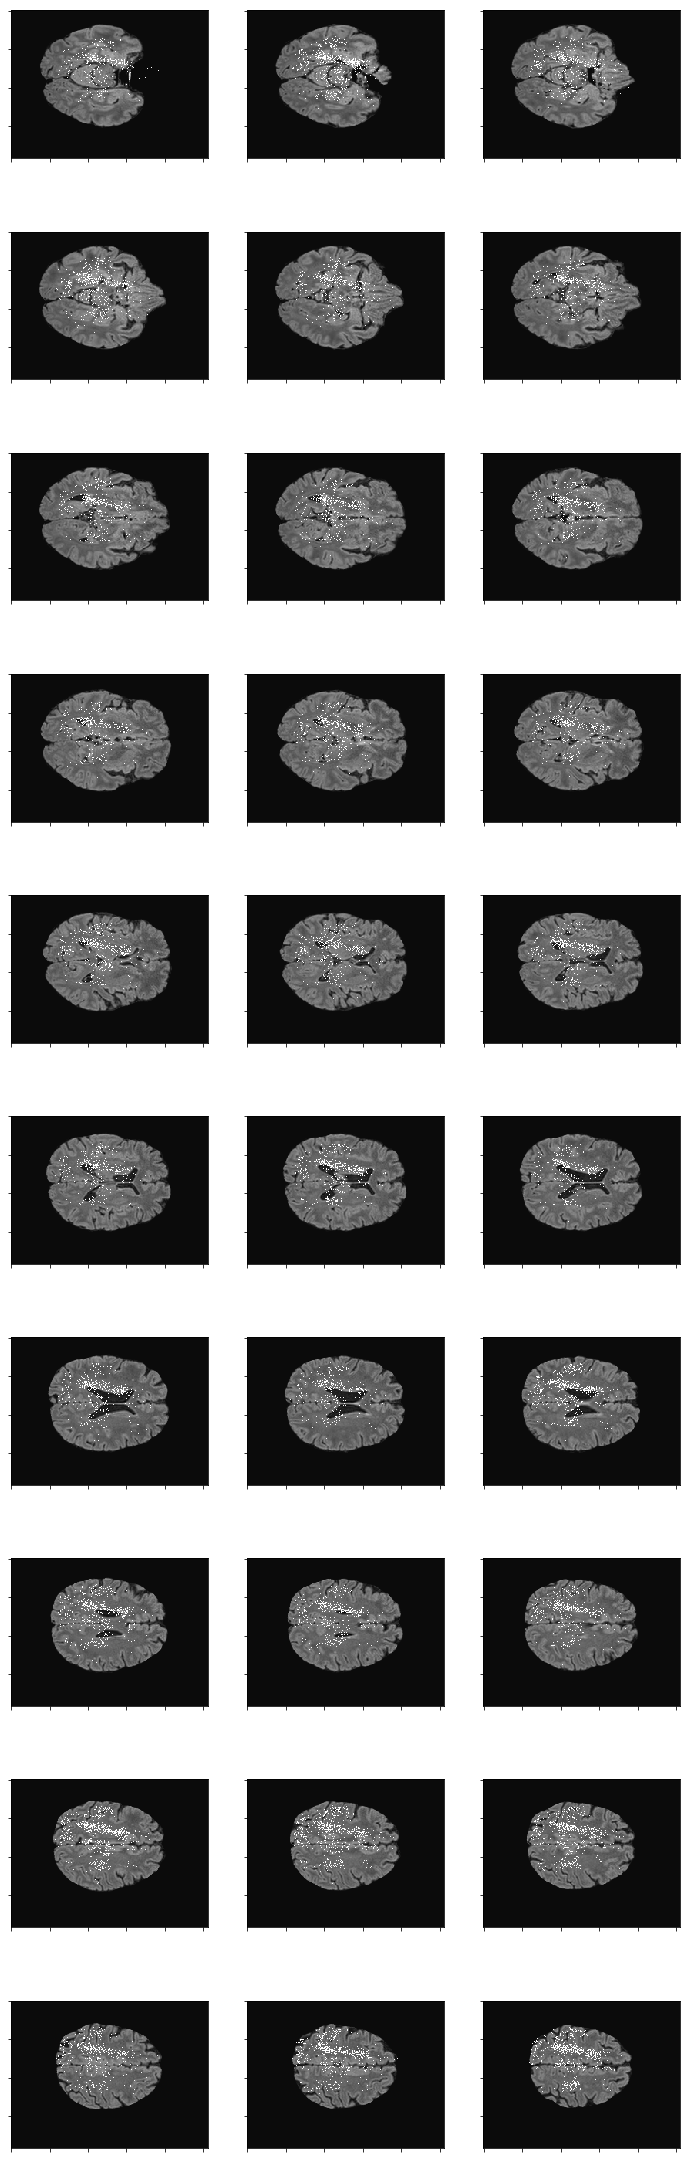

In [56]:
plot_brain(np.ma.masked_where(np.abs(grads[3]) > 5, test_tensor[3]))

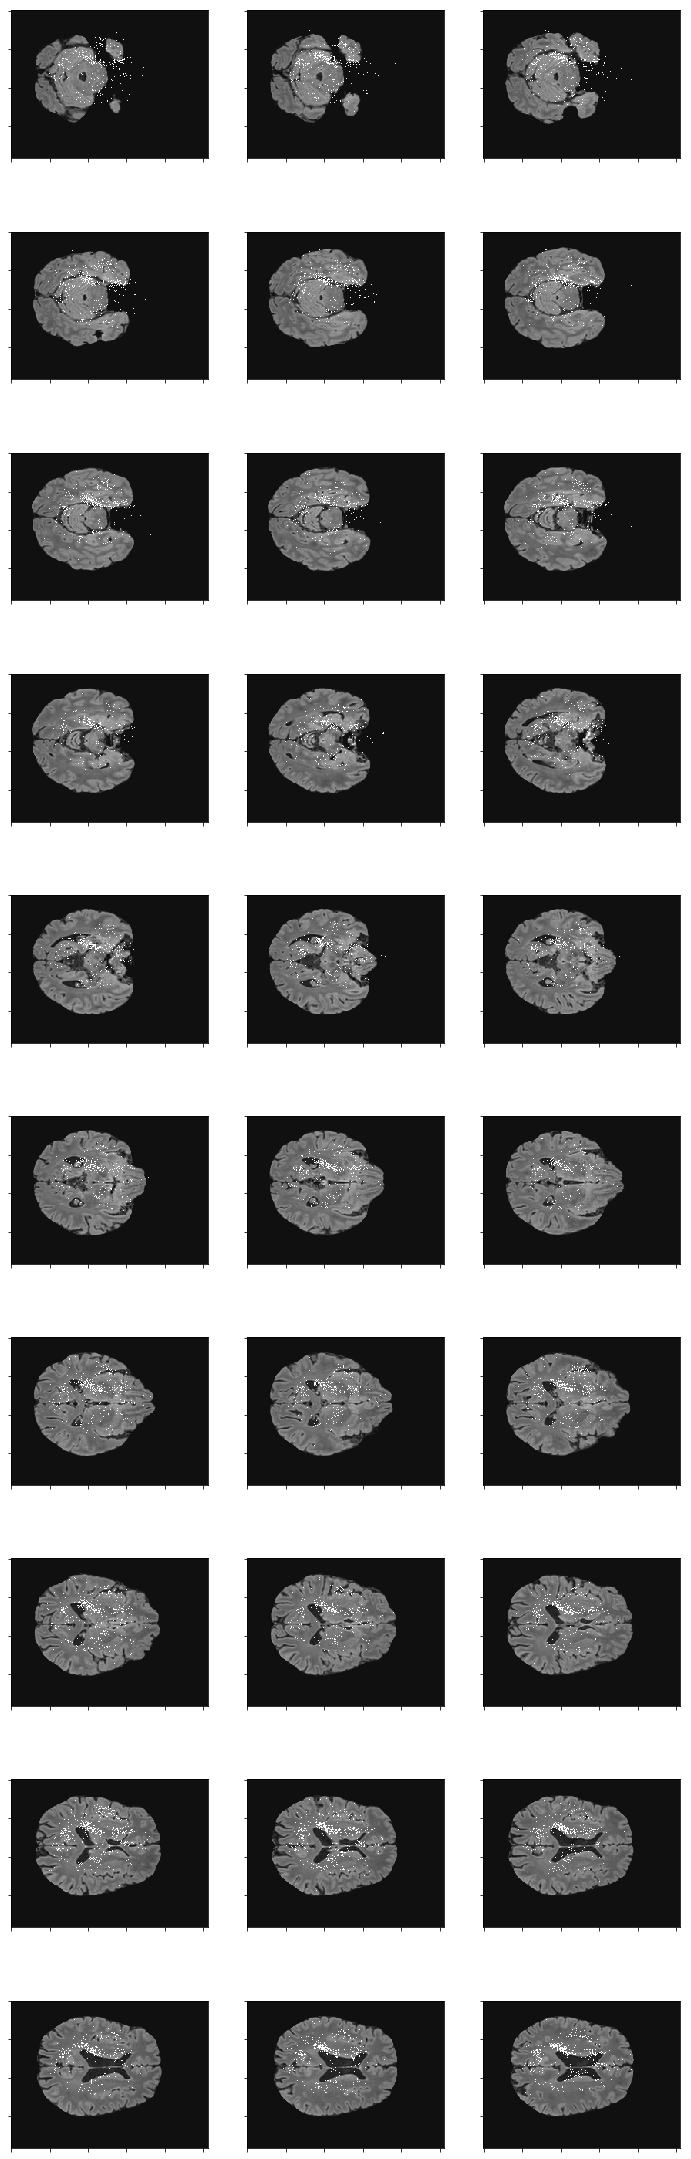

In [57]:
plot_brain(np.ma.masked_where(np.abs(grads[2]) > 5, test_tensor[2]))

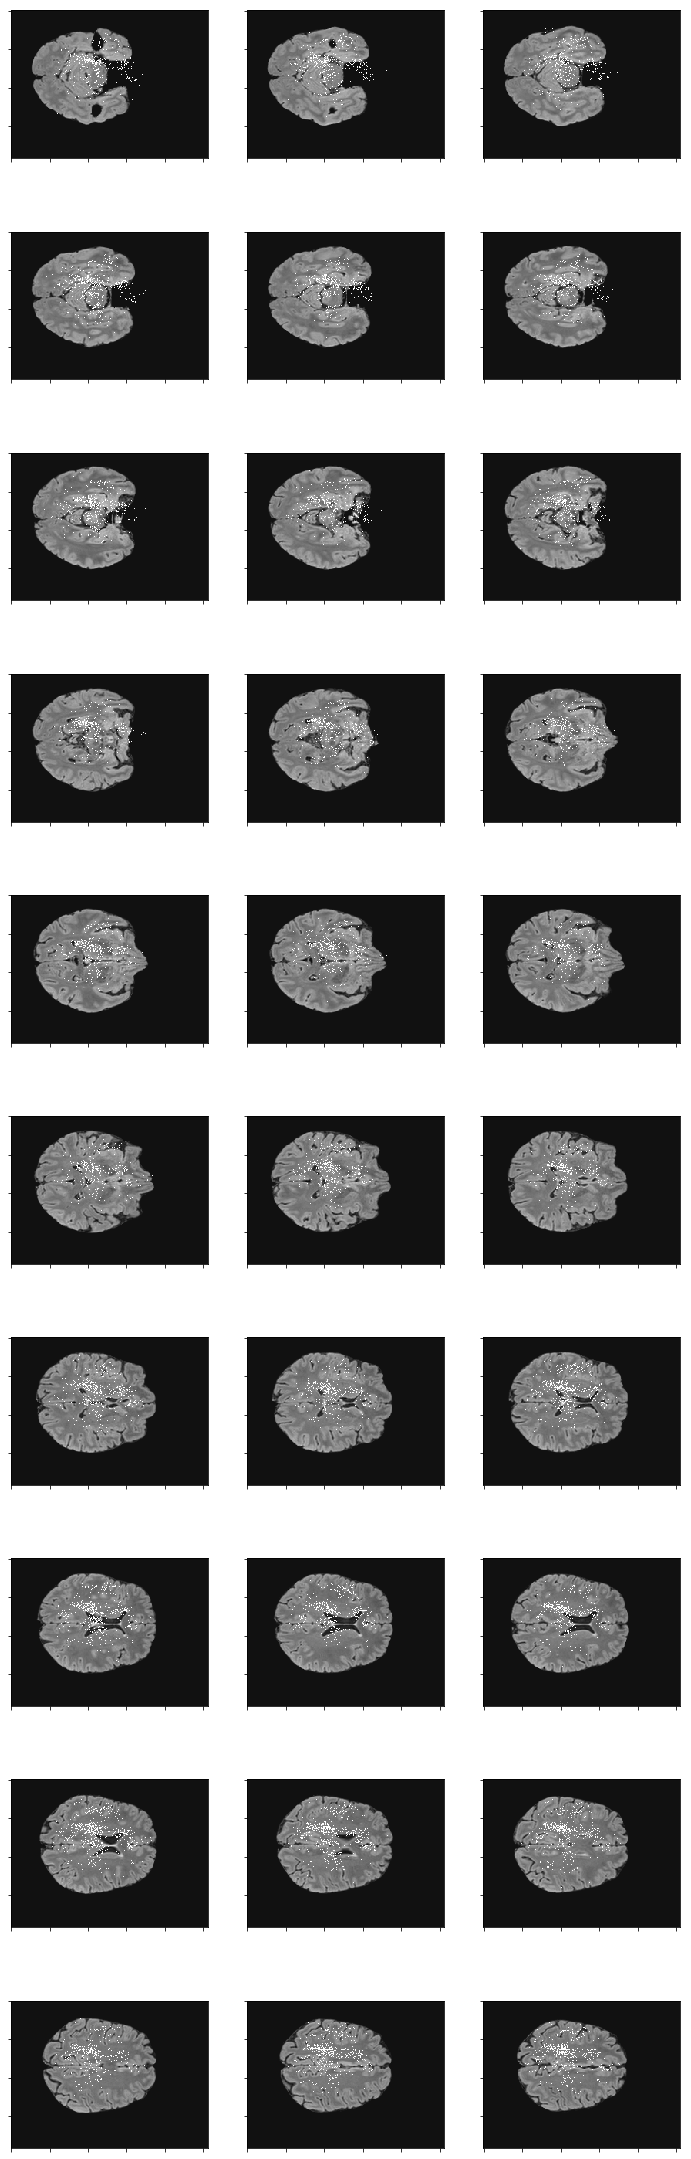

In [58]:
plot_brain(np.ma.masked_where(np.abs(grads[4]) > 5, test_tensor[4]))

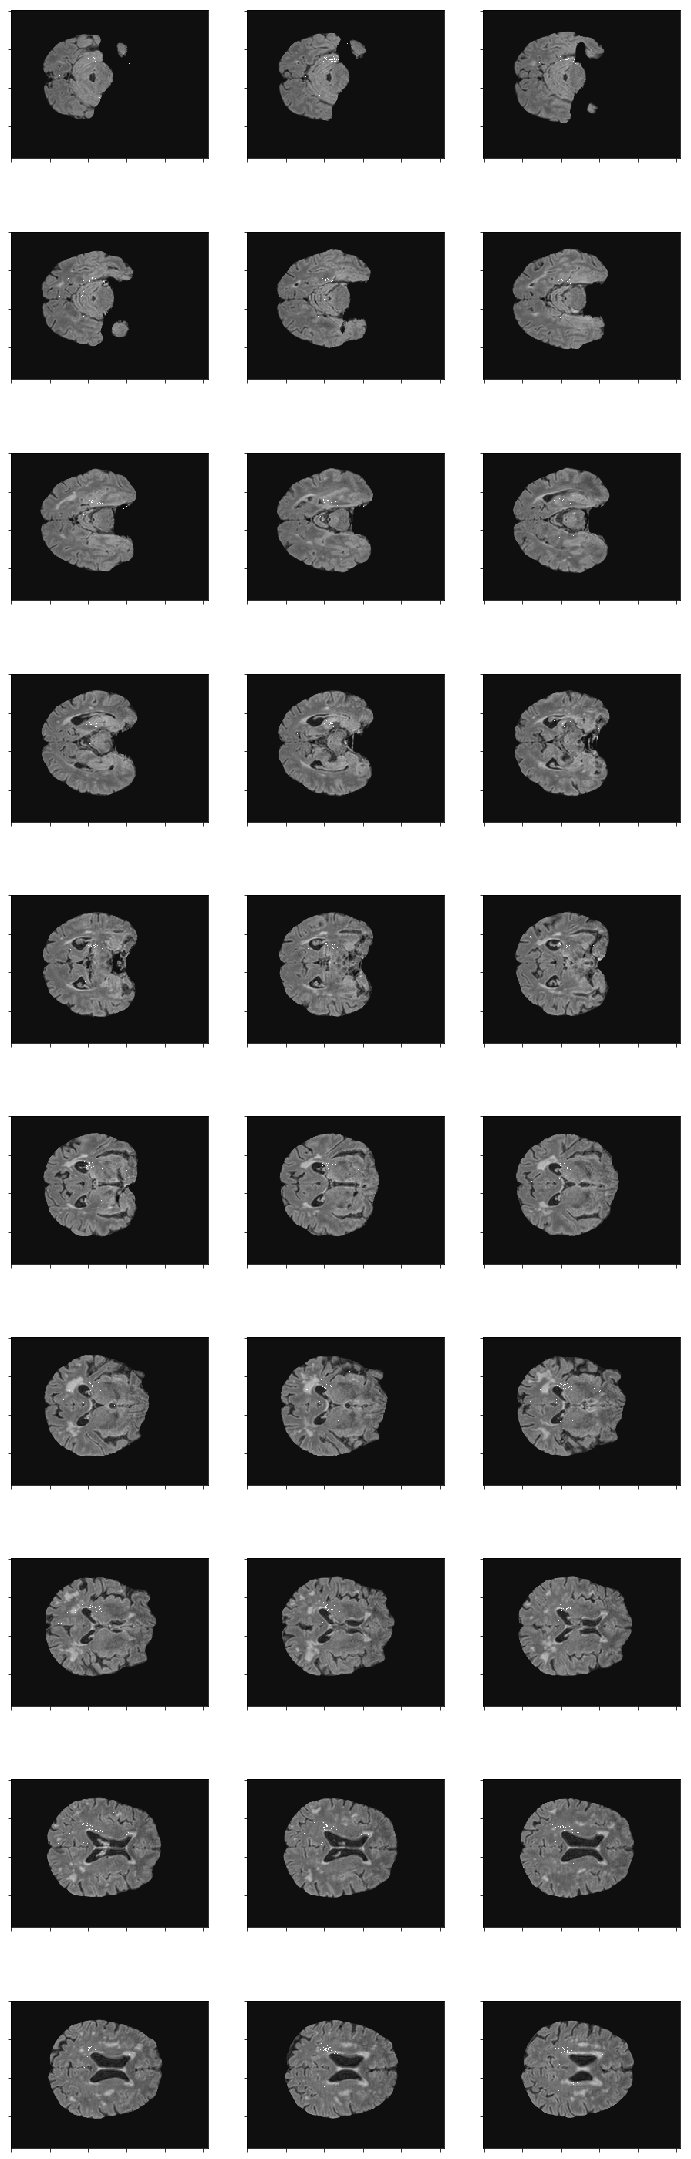

In [60]:
plot_brain(np.ma.masked_where(np.abs(grads[5]) > 3, test_tensor[5]))

- do this with hyperintensity
- ventricular volumes
- volumes
- move the window up less stem